<a href="https://colab.research.google.com/github/sdgroeve/D012554_Machine_Learning_2023/blob/main/03_image_classification_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
#@title
import requests
from pathlib import Path

request = requests.get("https://raw.githubusercontent.com/sdgroeve/D012554_Machine_Learning_2023/main/utils/utils.py")
with open("utils.py", "wb") as f:
  f.write(request.content)

from utils import plot_decision_boundary

In [138]:
#@title
!pip install tqdm
!pip install torchmetrics

# 3. Image Classification in PyTorch


In [139]:
import torch
from torch import nn

torch.manual_seed(46)

# Check PyTorch version
torch.__version__

'2.2.1+cu121'

## Preparing the data

We will use [`torchvision`](https://pytorch.org/vision/stable/index.html) to load our dataset. This library contains datasets, model architectures and image transformations often used for computer vision prediction tasks.

In [140]:
# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"torchvision version: {torchvision.__version__}")

torchvision version: 0.17.1+cu121


We will train our model on the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, made by Zalando Research, that contains grayscale images of 10 different kinds of clothing.

To download it, we provide the following parameters:
* `root: str` - which folder do you want to download the data to?
* `train: Bool` - do you want the training or test split?
* `download: Bool` - should the data be downloaded?
* `transform: torchvision.transforms` - what transformations would you like to do on the data?
* `target_transform` - you can transform the targets (labels) if you like too.

Let's load the data using torchvision.

In [141]:
# train set
train_data = datasets.FashionMNIST(
    root="data",
    train=True, # get training data
    download=True,
    transform=ToTensor(), # images come as PIL format, we want to turn them into Torch tensors
    target_transform=None
)

# test set
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [143]:
# train set
train_data = datasets.CIFAR10(
    root="data",
    train=True, # get training data
    download=True,
    transform=ToTensor(), # images come as PIL format, we want to turn them into Torch tensors
    target_transform=None
)

# test set
test_data = datasets.CIFAR10(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

100%|██████████| 170498071/170498071 [00:06<00:00, 26677574.44it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


There are 60.000 training images and 10.000 testing images.

In [145]:
len(train_data), len(test_data)

(50000, 10000)

These are the classes:

In [146]:
class_names = train_data.classes
print(len(class_names))
class_names

10


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

The following code splits the training data into a training data and validation data.

In [148]:
#train_data, validation_data = torch.utils.data.random_split(train_data, [50000, 10000])
train_data, validation_data = torch.utils.data.random_split(train_data, [40000, 10000])

Let's take a look at the first image (data point) in the train set.

In [149]:
image, label = train_data[0]
image, label

(tensor([[[0.9922, 0.9765, 0.9804,  ..., 0.9216, 0.8745, 0.8471],
          [0.9882, 0.9765, 0.9804,  ..., 0.8627, 0.8431, 0.8196],
          [0.9922, 0.9843, 0.9922,  ..., 0.9255, 0.9098, 0.8902],
          ...,
          [0.5765, 0.6078, 0.4863,  ..., 0.2118, 0.2902, 0.2824],
          [0.3216, 0.1804, 0.1059,  ..., 0.2118, 0.2510, 0.2471],
          [0.0824, 0.0745, 0.0902,  ..., 0.2000, 0.2353, 0.2314]],
 
         [[1.0000, 0.9961, 1.0000,  ..., 0.9804, 0.9843, 0.9804],
          [1.0000, 0.9922, 0.9961,  ..., 0.9765, 0.9804, 0.9804],
          [1.0000, 0.9961, 0.9961,  ..., 0.9882, 0.9882, 0.9843],
          ...,
          [0.5765, 0.6000, 0.4745,  ..., 0.2980, 0.3922, 0.3922],
          [0.3333, 0.1961, 0.1255,  ..., 0.3176, 0.3725, 0.3725],
          [0.0980, 0.0863, 0.0980,  ..., 0.3176, 0.3647, 0.3608]],
 
         [[0.9882, 0.9725, 0.9765,  ..., 0.9725, 0.9647, 0.9725],
          [0.9843, 0.9725, 0.9725,  ..., 0.9647, 0.9608, 0.9608],
          [0.9882, 0.9765, 0.9765,  ...,

Each image is a tensor with the following shape.

In [150]:
image.shape

torch.Size([3, 32, 32])

The shape of the image tensor is `[1, 28, 28]` or more specifically:

```
[color_channels=1, height=28, width=28]
```

Having `color_channels=1` means the image is grayscale.

Let's plot the first image in the train set.

In [ ]:
#import matplotlib.pyplot as plt

#image, label = train_data[0]

#plt.imshow(image.squeeze(), cmap="gray")
#plt.title(class_names[label])

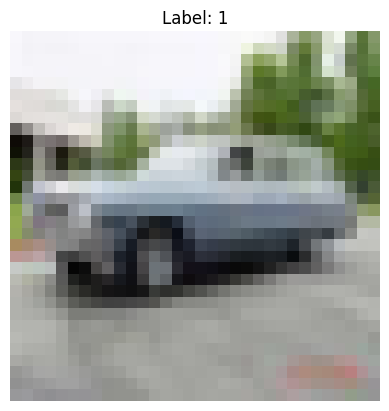

In [152]:
import matplotlib.pyplot as plt

# Assuming train_data is your dataset
image, label = train_data[1] # Get the first image and its label

# Permute the tensor from [C, H, W] to [H, W, C]
image = image.permute(1, 2, 0)

plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off') # Hide the axes
plt.show()

Let's plot some more.

In [ ]:
"""
fig = plt.figure(figsize=(14, 16))
rows, cols = 8, 8
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);
"""

Up till now we have updated the modelparameters once in each epoch. For large dataset this is highly inefficient.

It is better to partition the train set into smaller chucks of data, called **batches** (or **minibatches** as this approach works best for very small batch sizes), and update the modelparameters after each batch.  

A minibatch size of [32 data points](https://twitter.com/ylecun/status/989610208497360896?s=20&t=N96J_jotN--PYuJk2WcjMw) is a good place to start for most tasks.

The PyTorch `DataLoader` class makes using minibatches really easy.

In [153]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_dataloader = DataLoader(validation_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## Building the model

Since each image is a 2-dimensional (3 if you count the channel), we first **flatten** the image to just 1 dimension to prepare the input for the input layer of our neural network, i.e. each pixel is one feature.

In [154]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x, y = train_data[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([3, 32, 32]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 1024]) -> [color_channels, height*width]


In [155]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        num_neurons_layer_2 = 10

        self.layer_1 = nn.Linear(in_features=input_dim, out_features=num_neurons_layer_2)
        self.layer_2 = nn.Linear(in_features=num_neurons_layer_2, out_features=output_dim)

        self.flatten = nn.Flatten()

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.layer_1(x))
        x = self.layer_2(x)
        return x

### `__init()__`

Our neural network has two linear layers. The first layer `layer_1` has `input_dim` (the number of features in our dataset) input features that form the **input layer**. It has `num_neurons_layer_2` output features that form the **hidden layer** where these features are typically called **hidden neurons**.

The second layer `layer_2` has `num_neurons_layer_2` input features (neurons) and `output_dim` (which equals to 1 for two-class classification) output features, the **output layer**.

An example of this model architecture with `num_neurons_layer_2 = 6` can be seen [here](https://playground.tensorflow.org/#activation=sigmoid&batchSize=30&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=6&seed=0.86658&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

We will use the Rectified Linear Unit (ReLU) activation function in the hidden layer. In the output layer we use the sigmoid function (through `BCEWithLogitsLoss`, so we not to explicitly apply the sigmoid function during inference (see notebook about logistic regression)).

Next, we create an instance of the class `NeuralNetwork`.

In [156]:
# Two inputs x_1 and x_2
#input_dim = 784
input_dim = 32*32*3
# Single binary output
output_dim = 10

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model = NeuralNetwork(input_dim, output_dim)

model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.0037, -0.0049, -0.0166,  ..., -0.0084,  0.0137, -0.0120],
                      [ 0.0131,  0.0084,  0.0118,  ..., -0.0021,  0.0081,  0.0172],
                      [ 0.0128,  0.0097, -0.0046,  ...,  0.0167, -0.0103, -0.0101],
                      ...,
                      [ 0.0126,  0.0058, -0.0017,  ...,  0.0012,  0.0100, -0.0154],
                      [ 0.0055, -0.0093, -0.0080,  ...,  0.0068,  0.0091, -0.0009],
                      [-0.0065,  0.0105, -0.0131,  ..., -0.0027,  0.0007,  0.0020]])),
             ('layer_1.bias',
              tensor([ 0.0118, -0.0086,  0.0102, -0.0067,  0.0111,  0.0043, -0.0083,  0.0091,
                      -0.0014,  0.0167])),
             ('layer_2.weight',
              tensor([[ 0.2831,  0.2765, -0.2879,  0.1543,  0.3160, -0.2183,  0.2131, -0.2246,
                       -0.1957,  0.2564],
                      [ 0.2432,  0.1304,  0.3055,  0.2690, -0.2618, -0.3152,  0.0745,  0.0936,
   

### `forward()`

The `forward()` method applies the neural network to the provided feature vectors. Here we see that the data is first passed through `layer_1`, then through the ReLU activations that then pass through `layer_2`.

In [157]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

model.to(device)

cuda


NeuralNetwork(
  (layer_1): Linear(in_features=3072, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
)

In [158]:
import torchmetrics

metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

In [ ]:
"""
model.eval()
test_acc = 0, 0
with torch.inference_mode():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        # 1. Forward pass
        y_pred_logits = model(X)
        #y_pred = torch.softmax(y_pred_logits.squeeze(), dim=0)

        # 3. Calculate accuracy (preds need to be same as y_true)
        metric.update(y_pred_logits, y)
"""

model.train()

test_acc = metric.compute()

## Print out what's happening
print(f"\nTest acc: {test_acc:.2f}%\n")

## Training the model

We use `BCEWithLogitsLoss` as the loss function and SGD, `torch.optim.SGD(params, lr)` as the optimizer.

In [159]:
learning_rate = 0.01

#the loss function
loss_func = nn.CrossEntropyLoss()

#the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Now we can create and run our training and validation loop.



In [160]:
#number of times we iterate trough the train set
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
      X = X.to(device)
      y = y.to(device)
      #step 1
      predictions_train = model(X)

      #step 2
      loss = loss_func(predictions_train, y)
      train_loss += loss

      #step 3
      optimizer.zero_grad()

      #step 4
      loss.backward()

      #step 5
      optimizer.step()

    train_loss /= len(train_dataloader)

    model.eval()
    val_loss = 0
    with torch.inference_mode():
        for X, y in validation_dataloader:
            X = X.to(device)
            y = y.to(device)

            # 1. Forward pass
            y_pred_logits = model(X)
            y_pred = torch.softmax(y_pred_logits.squeeze(), dim=0)

            # 2. Calculate loss (accumatively)
            val_loss += loss_func(y_pred_logits, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            metric.update(y_pred_logits, y)

        val_loss /= len(validation_dataloader)

    val_acc = metric.compute()
    metric.reset()

    ## Print out what's happening
    print(f"Train loss: {train_loss:.5f} | Validation loss: {val_loss:.5f}, Validation acc: {val_acc:.2f}%")

    model.train()


Train loss: 2.03367 | Validation loss: 1.93216, Validation acc: 0.28%
Train loss: 1.87003 | Validation loss: 1.84432, Validation acc: 0.34%
Train loss: 1.82878 | Validation loss: 1.86982, Validation acc: 0.33%
Train loss: 1.80452 | Validation loss: 1.80249, Validation acc: 0.36%
Train loss: 1.78432 | Validation loss: 1.77878, Validation acc: 0.36%
Train loss: 1.76936 | Validation loss: 1.77766, Validation acc: 0.37%
Train loss: 1.75458 | Validation loss: 1.77404, Validation acc: 0.36%
Train loss: 1.74301 | Validation loss: 1.77847, Validation acc: 0.37%
Train loss: 1.73096 | Validation loss: 1.74389, Validation acc: 0.38%
Train loss: 1.71883 | Validation loss: 1.75109, Validation acc: 0.37%


In [161]:
model.eval()
test_acc = 0
with torch.inference_mode():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        # 1. Forward pass
        y_pred_logits = model(X)
        #y_pred = torch.softmax(y_pred_logits.squeeze(), dim=0)

        # 3. Calculate accuracy (preds need to be same as y_true)
        metric.update(y_pred_logits, y)

model.train()

test_acc = metric.compute()

## Print out what's happening
print(f"\nTest acc: {test_acc:.2f}%\n")


Test acc: 0.38%



In [169]:
class CNN(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            #nn.Linear(in_features=hidden_units*7*7,
            #          out_features=output_shape)
            nn.Linear(in_features=hidden_units*8*8,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [170]:
#model = CNN(input_shape=1,
#    hidden_units=10,
#    output_shape=len(class_names)).to(device)

model = CNN(input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model

CNN(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=10, bias=True)
  )
)

In [171]:
learning_rate = 0.1

#the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [172]:
#number of times we iterate trough the train set
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
      X = X.to(device)
      y = y.to(device)
      #step 1
      predictions_train = model(X)

      #step 2
      loss = loss_func(predictions_train, y)
      train_loss += loss

      #step 3
      optimizer.zero_grad()

      #step 4
      loss.backward()

      #step 5
      optimizer.step()

    model.eval()
    val_loss = 0
    with torch.inference_mode():
        for X, y in validation_dataloader:
            X = X.to(device)
            y = y.to(device)

            # 1. Forward pass
            y_pred_logits = model(X)
            y_pred = torch.softmax(y_pred_logits.squeeze(), dim=0)

            # 2. Calculate loss (accumatively)
            val_loss += loss_func(y_pred_logits, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            metric.update(y_pred_logits, y)

        val_loss /= len(validation_dataloader)

    val_acc = metric.compute()

    metric.reset()

    ## Print out what's happening
    print(f"Train loss: {train_loss:.5f} | Validation loss: {val_loss:.5f}, Validation acc: {val_acc:.2f}%")

    model.train()

Train loss: 2538.82471 | Validation loss: 1.65511, Validation acc: 0.39%
Train loss: 1897.58350 | Validation loss: 1.38974, Validation acc: 0.50%
Train loss: 1683.78821 | Validation loss: 1.43563, Validation acc: 0.51%
Train loss: 1585.41504 | Validation loss: 1.26269, Validation acc: 0.55%
Train loss: 1522.01282 | Validation loss: 1.21259, Validation acc: 0.58%
Train loss: 1484.95239 | Validation loss: 1.21559, Validation acc: 0.57%
Train loss: 1457.41797 | Validation loss: 1.23613, Validation acc: 0.57%
Train loss: 1434.15930 | Validation loss: 1.18507, Validation acc: 0.59%
Train loss: 1420.91638 | Validation loss: 1.21841, Validation acc: 0.58%
Train loss: 1405.85718 | Validation loss: 1.16001, Validation acc: 0.59%


## Computing predictions and evaluating the model


In [173]:
model.eval()
test_acc = 0
with torch.inference_mode():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        # 1. Forward pass
        y_pred_logits = model(X)
        #y_pred = torch.softmax(y_pred_logits.squeeze(), dim=0)

        # 3. Calculate accuracy (preds need to be same as y_true)
        metric.update(y_pred_logits, y)

model.train()

test_acc = metric.compute()

## Print out what's happening
print(f"\nTest acc: {test_acc:.2f}%\n")


Test acc: 0.59%

